# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 1 : Reservas de Hotel </center>
## <center>Árboles de Decisión </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044

## Tabla de contenidos
- [Importación y carga de datasets](#imports)
- [Preprocesamiento](#preprocessing)
- [Encoding](#encoding)
- [Split train/test](#split)
- [Grid Search](#gridsearch)
- [Decision Tree](#decisiontree)
     - [Metricas y matriz de confusion](#metrics)
- [Visualización del árbol](#visualizacion)
     - [Feature importance](#featureimportance)
- [Submission](#submission)

## Importación y carga de datasets <a name="imports"></a>

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer

import pickle

#semilla
RANDOM_STATE = 42

In [151]:
original = pd.read_csv('./Datasets/hotels_procesado.csv')
df_train = original.copy()
df_test = pd.read_csv('./Datasets/hotels_test.csv').copy()

## Procesamiento de datos <a name="preprocessing"></a>

### Dataset de Train

Vamos a eliminar del dataset las columnas que no utilizaremos para el entrenamiento del modelo.

In [152]:
df_train.drop(['id', 'arrival_date'], axis='columns', inplace=True)

Convertimos las columnas de ``'company'`` y ``'agent'`` que tienen valores categóricos a valores numéricos para poder utilizarlas en el modelo.

In [153]:
df_train['company'] = df_train['company'].apply(lambda x: 0 if x == 'Sin compania' else x).astype('float64').astype('int64')
df_train['agent'] = df_train['agent'].apply(lambda x: 0 if x == 'Sin agente' else x).astype('float64').astype('int64')

In [154]:
df_train.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,0,No Deposit,9,0,0,Transient,115.5,0,1,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,No Deposit,0,0,0,Transient,42.0,1,0,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,0,No Deposit,9,0,0,Transient,229.0,0,2,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,0,Non Refund,154,0,0,Transient,75.0,0,0,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,0,No Deposit,20,0,0,Transient-Party,75.0,0,1,0


### Dataset de Test

Ahora hacemos lo mismo en el dataset de test.

In [155]:
df_test.drop(['reservation_status_date'], axis='columns', inplace=True)

In [156]:
df_test['children'] = df_test['children'].astype('int64')

Tenemos que hacer tratamiento de datos nulos como lo hicimos en el dataset de train.

In [157]:
df_test['company'] = df_test['company'].fillna(0).astype('int64')
df_test['agent'] = df_test['agent'].fillna(0).astype('int64')
df_test['country'] = df_test['country'].fillna('Desconocido')

In [158]:
df_test.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id
0,City Hotel,277,2016,November,46,7,1,2,2,0,...,0,Non Refund,0,0,0,Transient,100.0,0,0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e
1,City Hotel,286,2016,May,20,11,0,4,2,0,...,0,No Deposit,30,0,176,Transient-Party,101.0,0,0,aba9aac2-4495-4645-a60e-90328713c999
2,City Hotel,0,2016,August,35,23,0,1,3,0,...,0,No Deposit,0,0,0,Transient,225.0,0,2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad
3,Resort Hotel,196,2016,October,44,29,2,5,2,2,...,0,No Deposit,240,0,0,Transient,96.0,0,0,ce1b400e-afa1-4946-bdff-004b859eb61c
4,Resort Hotel,232,2016,November,48,26,2,1,2,0,...,0,Non Refund,11,0,0,Transient,30.0,0,0,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214


In [159]:
# show countries first 10
df_train['country'].value_counts().head(11)

PRT    23273
GBR     4930
FRA     4344
ESP     3588
DEU     2993
ITA     1705
IRL     1412
BRA     1019
BEL     1001
NLD      888
USA      870
Name: country, dtype: int64

In [160]:
# group the other countries in value 'other'
df_train['country'] = df_train['country'].apply(lambda x: 'Other' if x not in ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA'] else x)
df_train['country'].value_counts()

PRT      23273
Other     7109
GBR       4930
FRA       4344
ESP       3588
DEU       2993
ITA       1705
IRL       1412
BRA       1019
BEL       1001
NLD        888
USA        870
Name: country, dtype: int64

In [161]:
df_test['country'] = df_test['country'].apply(lambda x: 'Other' if x not in ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA'] else x)
df_test['country'].value_counts()

PRT      12029
Other     3504
GBR       2387
FRA       2118
ESP       1757
DEU       1405
ITA        868
IRL        681
BRA        483
BEL        471
USA        420
NLD        412
Name: country, dtype: int64

In [162]:
# show assigned room types first 10
df_train['assigned_room_type'].value_counts().head(10)

A    35672
D    11042
E     3165
F     1216
G      707
B      626
C      455
H      170
K       50
I       29
Name: assigned_room_type, dtype: int64

In [163]:
# group the other room types in value 'other'
df_train['assigned_room_type'] = df_train['assigned_room_type'].apply(lambda x: 'Other' if x not in ['A', 'D', 'E', 'F', 'G'] else x)
df_train['assigned_room_type'].value_counts()

A        35672
D        11042
E         3165
Other     1330
F         1216
G          707
Name: assigned_room_type, dtype: int64

In [164]:
df_test['assigned_room_type'] = df_test['assigned_room_type'].apply(lambda x: 'Other' if x not in ['A', 'D', 'E', 'F', 'G'] else x)
df_test['assigned_room_type'].value_counts()

A        17218
D         5316
E         1576
Other     1144
F          764
G          517
Name: assigned_room_type, dtype: int64

In [165]:
df_train['reserved_room_type'].value_counts().head(10)

A    39724
D     8800
E     2684
F      926
G      562
B      263
H      135
C       38
Name: reserved_room_type, dtype: int64

In [166]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].apply(lambda x: 'Other' if x not in ['A', 'D', 'E', 'F', 'G'] else x)
df_train['reserved_room_type'].value_counts()

A        39724
D         8800
E         2684
F          926
G          562
Other      436
Name: reserved_room_type, dtype: int64

In [167]:
df_test['reserved_room_type'] = df_test['reserved_room_type'].apply(lambda x: 'Other' if x not in ['A', 'D', 'E', 'F', 'G'] else x)
df_test['reserved_room_type'].value_counts()

A        19366
D         4176
E         1352
F          630
Other      569
G          442
Name: reserved_room_type, dtype: int64

In [168]:
# show agent first 10
df_train['agent'].value_counts().head(10)

9      15597
240     6326
0       5906
1       3732
7       1455
6       1446
14      1441
250      818
241      688
37       680
Name: agent, dtype: int64

In [169]:
# GROUP THE OTHER AGENTS IN VALUE 'other'
df_train['agent'] = df_train['agent'].apply(lambda x: 10000 if x not in [9, 240, 0, 1, 7, 6, 14] else x)
df_train['agent'].value_counts()

10000    17229
9        15597
240       6326
0         5906
1         3732
7         1455
6         1446
14        1441
Name: agent, dtype: int64

In [170]:
df_test['agent'] = df_test['agent'].apply(lambda x: 10000 if x not in [9, 240, 0, 1, 7, 6, 14] else x)
df_test['agent'].value_counts()

10000    8763
9        7324
0        3363
240      2989
1        1983
6         717
14        700
7         696
Name: agent, dtype: int64

In [171]:
df_train.drop(['company'], axis='columns', inplace=True)
df_test.drop(['company'], axis='columns', inplace=True)

## Encoding <a name="onehot"></a>

Vamos a utilizar la funcion OneHotEncoder para convertir las columnas categóricas de ambos datasets a numéricas para poder utilizarlas en el modelo de árbol de decisión.

In [172]:
encoder = OneHotEncoder(handle_unknown='ignore')

### Dataset de Train

In [173]:
train_one_hot = encoder.fit_transform(df_train[['agent', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']])

train_columns = encoder.get_feature_names_out(['agent','country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'])

train_encoded = pd.DataFrame(train_one_hot.toarray(), columns=train_columns)

In [174]:
train_encoded.shape

(53132, 156)

In [175]:
train_ = pd.concat([df_train, train_encoded], axis=1)

In [176]:
train_.drop(['agent','country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'is_canceled'], axis='columns', inplace=True)

In [177]:
train_.shape

(53132, 170)

### Dataset de Test

In [178]:
test_one_hot = encoder.fit_transform(df_test[['agent','country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                                      'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']])

test_columns = encoder.get_feature_names_out(['agent','country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                                              'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'])

test_encoded = pd.DataFrame(test_one_hot.toarray(), columns=test_columns)


In [179]:
test_ = pd.concat([df_test, test_encoded], axis=1)

In [180]:
test_.drop(['agent','country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type',
            'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'id'], axis='columns', inplace=True)


In [181]:
test_.shape

(26535, 170)

### Tratamiento adicional

Luego de tener ambos datasets con las columnas categóricas encodeadas, tuvimos que completar ambos datasets con las columnas faltantes para que tengan las mismas columnas.

In [193]:
missing_cols = set(train_.columns) - set(test_.columns)
for col in missing_cols:
    test_[col] = 0

In [194]:
missing_cols = set(test_.columns) - set(train_.columns)
for col in missing_cols:
    train_[col] = 0

También tuvimos que reordenar las columnas para que tengan el mismo orden.

In [195]:
column_order = train_.columns
test_ = test_.reindex(columns=column_order)

### Guardo los datasets encodeados

In [196]:
train_.to_csv('./Datasets/train_encoded.csv')
test_.to_csv('./Datasets/test_encoded.csv')

## Split train/test <a name="split"></a>

Ahora vamos a dividir el dataset de train para poder entrenar el modelo y luego testearlo.

In [182]:
x = train_.copy()
y = df_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

Verificamos la cantidad de datos en cada set y como quedaron balanceados esos datos.

In [183]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


## Grid search <a name="gridsearch"></a>

Utilizamos Grid Search para encontrar los mejores hiperparámetros para el modelo.

También utilizamos cross validation (10 folds).

Decidimos optimizar F1 Score ya que después en Kaggle se utiliza esa métrica para evaluar el modelo.

In [190]:
folds = 10

kfoldcv = StratifiedKFold(n_splits=folds)

# Parametros a optimizar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(1,15)),
               'max_depth':list(range(1,15))
    }

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

# Clasificador
base_tree = DecisionTreeClassifier()

#Grid Search
gs = GridSearchCV(base_tree, params_grid,
                  cv=kfoldcv,
                  scoring=scorer_fn,
                  verbose=2)

gs.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.2s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.9s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.1s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.4s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.3s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.8s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   0.9s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   2.9s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=8, min_samples_split=11; total time=   1.0s
[CV] END c

c:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files\Python38\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "c:\Program Files\Python38\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "c:\Program Files\Python38\lib\site-packages\sklearn\base.py", 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14]},
                   scoring=make_scorer(f1_score), verbose=2)

Al finalizar el Grid Search, obtuvimos los siguientes resultados:

In [191]:
print('Mejores parámetros: {}'.format(gs.best_params_))
print('Mejor métrica: {}'.format(gs.best_score_))

Mejores parámetros: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 12, 'criterion': 'gini'}
Mejor métrica: 0.8468067258047227


## Decision Tree <a name="decisiontree"></a>

Creamos el modelo de árbol de decisión con los mejores hiperparámetros encontrados en el Grid Search y lo entrenamos con el dataset de train.

In [199]:
arbol = DecisionTreeClassifier(random_state=RANDOM_STATE).set_params(**gs.best_params_)

modelo = arbol.fit(X=x_train, y=y_train)

Realizamos una predicción con el dataset de test y obtuvimos los siguientes resultados:

In [200]:
y_pred = modelo.predict(x_test)

In [29]:
pickle.dump(arbol, open('decision_tree_grupo29.pickle', 'wb'))

### Métricas y matriz de confusión <a name="metrics"></a>

In [201]:
print(f'Best Training Accuracy: {modelo.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(gs.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8613680361368036
Best Testing Accuracy: 0.8442910915934755
Cross-val-score: 0.8451027041536859


Creamos una matriz de confusión y la graficamos para ver los resultados de la predicción.

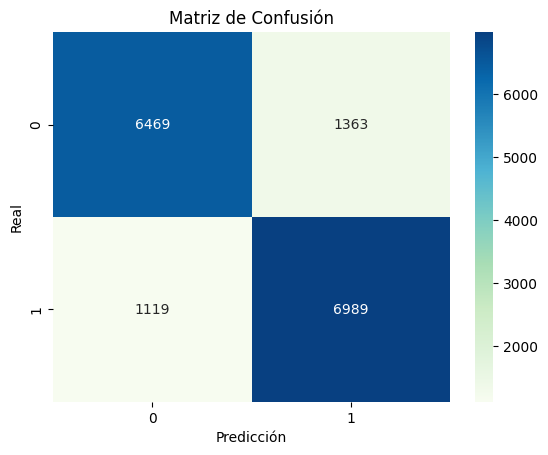

In [202]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g').set(title='Matriz de Confusión', xlabel='Predicción', ylabel='Real')
plt.show()

Vamos a ver el porcentaje de aciertos y errores del modelo.

In [203]:
# True Positives:
TP = 7025
# True Negatives:
TN = 6550
# False Posititives: 
FP = 1282
# False Negatives: 
FN = 1083
total = TP + TN + FP + FN

print(f'Clasificadas correctamente: {np.round((TP+TN)/total*100)}%')
print(f'Reservas canceladas clasificadas correctamente: {np.round(TP/(TP+FN)*100)}%')
print(f'Reservas no canceladas clasificadas correctamente: {np.round(TN/(TN+FP)*100)}%')
print(f'Reservas predecidas canceladas que fueron canceladas: {np.round(TP/(TP+FP)*100)}%')
print(f'Reservas predecidas no canceladas que fueron no canceladas: {np.round(TN/(TN+FN)*100)}%')

Clasificadas correctamente: 85.0%
Reservas canceladas clasificadas correctamente: 87.0%
Reservas no canceladas clasificadas correctamente: 84.0%
Reservas predecidas canceladas que fueron canceladas: 85.0%
Reservas predecidas no canceladas que fueron no canceladas: 86.0%


Calculamos las métricas accuracy, precision, recall y f1 score.

- Accuracy: Mide qué porcentaje de veces el modelo predice correctamente la etiqueta de clase.
- Precision: Mide la proporción de resultados positivos que son realmente positivos.
- Recall: Mide la proporción de resultados positivos que realmente son positivos en relación al total de positivos existentes.
- F1 Score: Es una medida que combina la precisión y el recall en una única métrica que representa el equilibrio entre ambas. 

In [204]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8442910915934755
Recall: 0.8619881598421312
Precision: 0.8368055555555556
f1 score: 0.8492102065613608


In [205]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7832
           1       0.84      0.86      0.85      8108

    accuracy                           0.84     15940
   macro avg       0.84      0.84      0.84     15940
weighted avg       0.84      0.84      0.84     15940



## Visualizacion del arbol <a name="visualizacion"></a>

Graficamos una porcion representativa del arbol de decisión.

In [206]:
modelo.classes_

array([0, 1], dtype=int64)

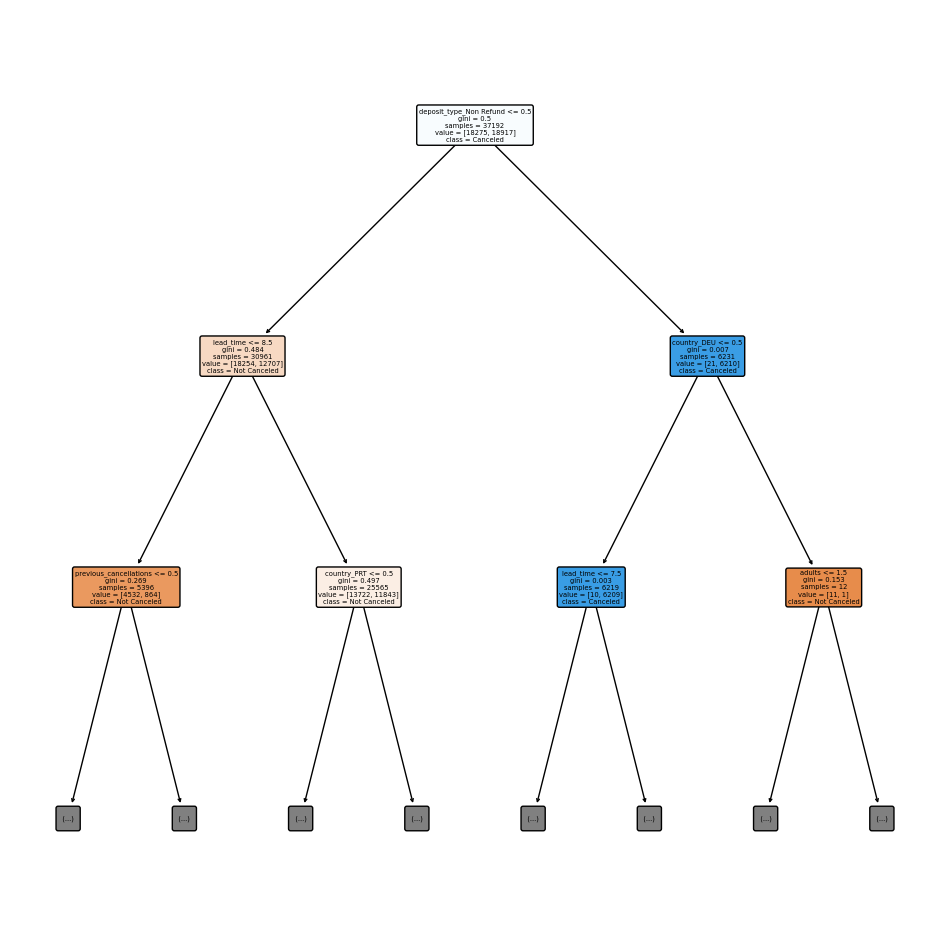

In [207]:
plt.figure(figsize=(12, 12))

tree_plot = plot_tree(modelo,
                           max_depth=2,
                           feature_names=x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])
plt.show(tree_plot)

### Feature importance <a name="featureimportance"></a>

Podemos ver las features mas importantes del modelo.

In [210]:
feat_imps = arbol.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x.columns), reverse=True):
  if feat_imp > 0.01:
    print('{}: {}'.format(feat,feat_imp))

deposit_type_Non Refund: 0.3102731977775662
agent_9: 0.13674497789936152
lead_time: 0.100154049120026
country_PRT: 0.07660423370764816
total_of_special_requests: 0.07458194427079948
agent_240: 0.06455156478900849
required_car_parking_spaces: 0.0416946749148595
customer_type_Transient: 0.023583945546197003
previous_cancellations: 0.02311225873429725
arrival_date_year_2015: 0.014421447581752529
arrival_date_year_2017: 0.014011084557613882
adr: 0.013468359572215588
booking_changes: 0.01275165155036372


Las que más influyen en la predicción son ``'deposit_type'``, ``'lead_time'``, ``'country'``, ``'total_of_special_requests'`` y ``'market_segment'``.

También podemos ver que condiciones evalua el árbol en cada nodo.

In [211]:
reglas = export_text(arbol, feature_names=list(x.columns), max_depth=2)
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- lead_time <= 8.50
|   |   |--- previous_cancellations <= 0.50
|   |   |   |--- truncated branch of depth 10
|   |   |--- previous_cancellations >  0.50
|   |   |   |--- class: 1
|   |--- lead_time >  8.50
|   |   |--- country_PRT <= 0.50
|   |   |   |--- truncated branch of depth 10
|   |   |--- country_PRT >  0.50
|   |   |   |--- truncated branch of depth 10
|--- deposit_type_Non Refund >  0.50
|   |--- country_DEU <= 0.50
|   |   |--- lead_time <= 7.50
|   |   |   |--- truncated branch of depth 2
|   |   |--- lead_time >  7.50
|   |   |   |--- truncated branch of depth 6
|   |--- country_DEU >  0.50
|   |   |--- adults <= 1.50
|   |   |   |--- class: 0
|   |   |--- adults >  1.50
|   |   |   |--- class: 0



Lo primero que evalúa el modelo es el ``'deposit_type'`` de tipo Non Refund, luego por la rama derecha continúa evaluando el ``'country'`` PRT y continuando por la rama derecha cataloga estas reservas como canceladas, a la izquierda evalúa el ``'customer_type'`` de tipo Transient y continúa evaluando hacia abajo.

Por la rama izquierda después de evaluar el ``'deposit_type'`` de tipo Non Refund, continúa evaluando por ``'previous_cancellations'`` y a la derecha las cataloga como canceladas, a la izquierda sigue con ``'market_segment'`` de tipo Online TA y continua evaluando hacia abajo.

## Submission <a name="submission"></a>

Generamos el archivo de submission para subir a Kaggle.

In [212]:
X_submission = test_.select_dtypes(exclude=['object'])
y_pred_test = modelo.predict(X_submission)

In [213]:
df_submission = pd.DataFrame({'id': df_test['id'], 'is_canceled': y_pred_test})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [41]:
df_submission.to_csv('submission11.csv', index=False)